In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [89]:
data = pd.read_csv('TM-1.csv')

In [90]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-90-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99972,0.99964,0.99937,0.99152,-0.23053
High,0.99972,1.0,0.99955,0.99968,0.99169,-0.22494
Low,0.99964,0.99955,1.0,0.9997,0.99186,-0.23644
Close,0.99937,0.99968,0.9997,1.0,0.99195,-0.22946
Adj Close,0.99152,0.99169,0.99186,0.99195,1.0,-0.27531
Volume,-0.23053,-0.22494,-0.23644,-0.22946,-0.27531,1.0


In [91]:
df = pd.DataFrame(data)

In [92]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [93]:
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [94]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [95]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [96]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(300, 1)


In [97]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 24.87906706684607
MAPE: 15.576823984547318
RMSE: 33.60681011796946


In [98]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[175.4360247316539, 175.15702558980945, 175.11082034738772, 175.16892044302108, 175.28188018845478, 175.4277881249796, 175.56179915207184, 175.69202686888332, 175.82576897253676, 175.9573397516537, 176.09787285930986, 176.23473386059214, 176.37474638247159, 176.51202677415927, 176.65180506768942, 176.78403069545863, 176.91342229902736, 177.05222722298592, 177.1868206889659, 177.32902471128244, 177.48181803144053, 177.63070885087097, 177.7683296679599, 177.91570824382916, 178.05574490208642, 178.18885147199813, 178.32597806322403, 178.45514141322852, 178.59607940565132, 178.7348830765937, 178.8785714654623, 179.0076086111168, 179.16245546862154, 179.32088958346424, 179.4674051346927, 179.61635889978322, 179.75132284674345, 179.8870418005965, 180.0268504316433, 180.1632271634478, 180.31249682986942, 180.46096294934642, 180.61241342476018, 180.7519666880072, 180.88396196369496, 181.0274008439631, 181.1696131896138, 181.30221808487704, 181.42999438274902, 181.55525503246645,

In [99]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[155.98484938 156.00454267 156.02423597 156.04392927 156.06362257
 156.08331587 156.10300917 156.12270246 156.14239576 156.16208906
 156.18178236 156.20147566 156.22116896 156.24086225 156.26055555
 156.28024885 156.29994215 156.31963545 156.33932874 156.35902204
 156.37871534 156.39840864 156.41810194 156.43779524 156.45748853
 156.47718183 156.49687513 156.51656843 156.53626173 156.55595502]


In [100]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[175.52131660861318, 175.27705178367617, 175.25584811006703, 175.32774748535292, 175.43850695645529, 175.56548616541573, 175.69923529839875, 175.83581011646197, 175.97356434158297, 176.11181083706262, 176.25026280028507, 176.38880052327875, 176.52737404137218, 176.6659624999109, 176.8045571944123, 176.9431544917297, 177.08175287543128, 177.2203517125766, 177.35895073898388, 177.4975498443868, 177.6361489827616, 177.77474813489846, 177.9133472927794, 178.0519464530579, 178.1905456143371, 178.32914477603398, 178.4677439379052, 178.60634309984914, 178.7449422618235, 178.88354142381053]


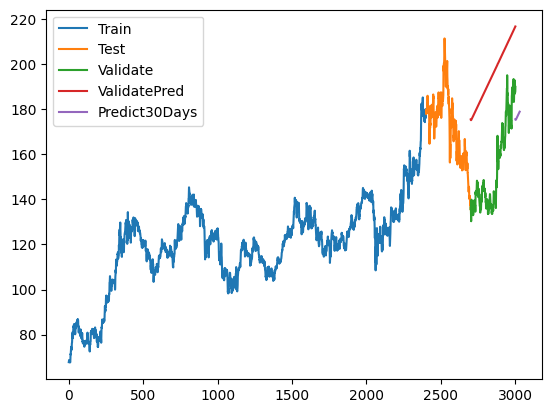

In [101]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()